# Covid-19 analysis
This Python3 notebook is based on the original [Pharo Smalltalk version](https://github.com/olekscode/CovidAnalysis) by Oleksandr Zaitsev. <br> The dataset for this Covid-19 analysis is publicly available ([see](#Download-latest-COVID-19-data)) and updated daily. Where appropriate some code extensions have been added to view the supplied data from a different angle.

#### Disclaimer 
August 2020. To prevent inappropriate conclusions drawn on this highly actual subject:
* As a Data Science beginner this Covid-19 analysis is purely intended for educational purposes.
* The outcome of the code cells in this notebook should be regarded as the *technical* result of the code and not be interpreted otherwise.
* I have no opinion on the dataset provided nor am I responsible for possible misinterpretation of the outcome

In [1]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline 
#this line above prepares IPython notebook for working with matplotlib

# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().

import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
#sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns #sets up styles and gives us more plotting options
import urllib.request
import pickle
import requests
import datetime

### Download latest COVID-19 data
Download the latest COVID-19 data from the [European Centre for Disease Prevention](https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide).

In [2]:
def dataCsvURL():
    return 'https://opendata.ecdc.europa.eu/covid19/casedistribution/csv'

In [3]:
def dataDirectory():
    return 'data/'

In [4]:
def dataCsvFile():
    return dataDirectory() + 'covidData.csv'

In [5]:
#Let's give it a try and save to CSV file
covidFile = requests.get(dataCsvURL())
open(dataCsvFile(), 'wb').write(covidFile.content)

2835223

### Read and clean data
Now read the data from the CSV file into a dataframe using pandas. Clean up to show the relevant columns.

In [6]:
def columnsToDisplay():
    return ["dateRep", "cases", "deaths", "countriesAndTerritories","popData2019"]

In [7]:
def columnsRenameDict():
    return {'dateRep':'date', 'countriesAndTerritories':'country', 'popData2019':'population' }

In [8]:
# Change date format to DD-MONTH-YYYY
# Convert population to integer. Caution: astype(int) gives error "Cannot convert non-finite values (NA or inf) to integer"
def preProcessing(df):
    df['date'] = pd.to_datetime(df['date'], dayfirst=True)
    df['date'] = df['date'].dt.strftime("%d %B %Y")
    df['population'] = df['population'].astype('Int64')

In [10]:
#df = pd.read_csv(dataCsvFile())
df = pd.read_csv(dataCsvFile(), usecols=columnsToDisplay())
df.rename(columns=columnsRenameDict(), inplace=True)
preProcessing(df)
df.head(20)


,date,cases,deaths,country,population
0,08 September 2020,96,3,Afghanistan,38041757
1,07 September 2020,74,2,Afghanistan,38041757
2,06 September 2020,20,0,Afghanistan,38041757
3,05 September 2020,16,0,Afghanistan,38041757
4,04 September 2020,45,1,Afghanistan,38041757
5,03 September 2020,38,3,Afghanistan,38041757
6,02 September 2020,9,0,Afghanistan,38041757
7,01 September 2020,34,4,Afghanistan,38041757
8,31 August 2020,19,0,Afghanistan,38041757
9,30 August 2020,3,0,Afghanistan,38041757


#### One country
The core of western civilization and a popular holiday destination:

In [11]:
#df[df.country=='Greece'].head() identical to:
df.query("country == 'Greece'").head()

,date,cases,deaths,country,population
15307,08 September 2020,139,5,Greece,10724599
15308,07 September 2020,138,4,Greece,10724599
15309,06 September 2020,186,1,Greece,10724599
15310,05 September 2020,202,1,Greece,10724599
15311,04 September 2020,241,5,Greece,10724599


### Top 10 countries of reported cases  (in numbers)
This is an aggregate action on the dataframe. As a beginner in Data science and Pandas I find it cumbersome to get these top 10 countries of reported cases. IMO **Pharo's Smalltalk** solution below is much cleaner and easier to understand.

```
(df group: 'cases' by: 'country' aggregateUsing: #sum)
	sortDescending
	head: 10.
```

To find the 10 countries having the least reported cases simply replace `head` by `tail`.

In [12]:
#df['country'].count()
#df['cases'].sum()
#df.sum()

casesPerCountry = df.groupby('country').sum()[['cases']]
sortedCasesPerCountry = casesPerCountry.sort_values(by=['cases'], ascending=False)
sortedCasesPerCountry.head(10)

,cases
country,
United_States_of_America,6300671
India,4280422
Brazil,4147794
Russia,1030690
Peru,691575
Colombia,671848
South_Africa,639362
Mexico,637509
Spain,525549


### Top 10 countries of reported cases  (relative to population)
Another approach is to collect the number of cases in a country relative to the population.

In [13]:
# Find 10 countries with relatively highest cases
populationPerCountry = df.groupby('country').mean()[['population']]
populationPerCountry['cases (%)']=casesPerCountry['cases'] / populationPerCountry['population'] * 100
populationPerCountry.sort_values(by=['cases (%)'], ascending=False).head(10)

,population,cases (%)
country,,
Qatar,2832071,4.249470
Bahrain,1641164,3.416843
Aruba,106310,2.334682
Panama,4246440,2.297878
Chile,18952035,2.238673
Kuwait,4207077,2.148451
San_Marino,34453,2.133341
Peru,32510462,2.127238
Brazil,211049519,1.965318


### Top 10 countries of reported deaths (in numbers)
To find the 10 countries having the least reported Covid-19 deaths simply replace `head` by `tail`.


In [14]:
casesPerCountry = df.groupby('country').sum()[['deaths']]
sortedCasesPerCountry = casesPerCountry.sort_values(by=['deaths'], ascending=False)
sortedCasesPerCountry.head(10)

,deaths
country,
United_States_of_America,189208
Brazil,126960
India,72775
Mexico,67781
United_Kingdom,41554
Italy,35553
France,30726
Peru,29976
Spain,29516


### Top 10 countries of reported deaths  (relative to population)
Another approach is to collect the number of deaths in a country relative to the population.

In [15]:
# Find 10 countries with relatively highest deaths
populationPerCountry = df.groupby('country').mean()[['population']]
populationPerCountry['deaths (%)']=casesPerCountry['deaths'] / populationPerCountry['population'] * 100
populationPerCountry.sort_values(by=['deaths (%)'], ascending=False).head(10)

,population,deaths (%)
country,,
San_Marino,34453,0.121905
Peru,32510462,0.092204
Belgium,11455519,0.086500
Andorra,76177,0.069575
Spain,46937060,0.062884
United_Kingdom,66647112,0.062349
Chile,18952035,0.061482
Bolivia,11513102,0.061269
Ecuador,17373657,0.060874


### Covid-19 spread in The Netherlands

In [16]:
country = "Netherlands"
df_country = df[df.country==country]
relevant_columns = ['date', 'cases', 'deaths']
covid_df_country = df_country[relevant_columns]
covid_df_country

,date,cases,deaths
26931,08 September 2020,797,0
26932,07 September 2020,925,2
26933,06 September 2020,654,4
26934,05 September 2020,744,2
26935,04 September 2020,421,0
...,...,...,...
27179,04 January 2020,0,0
27180,03 January 2020,0,0
27181,02 January 2020,0,0
27182,01 January 2020,0,0


### Max daily cases in The Netherlands
Find date when most cases were reported

In [17]:
maxDailyCases = covid_df_country['cases'].max()
print('Max daily cases ', country, ' ' , maxDailyCases)

covid_df_country[(covid_df_country.cases==maxDailyCases)]


Max daily cases  Netherlands   1335


,date,cases,deaths
27081,11 April 2020,1335,115


### Max daily deaths in The Netherlands
Find when most deaths were reported

In [18]:
maxDailyDeaths = covid_df_country['deaths'].max()
print('Max daily cases ', country, ' ' , maxDailyDeaths)
covid_df_country[(covid_df_country.deaths==maxDailyDeaths)]

Max daily cases  Netherlands   234


,date,cases,deaths
27084,08 April 2020,777,234


### Cumulative sum of cases and deaths
To find the total number of reported cases and deaths up to a date in the Netherlands

In [19]:
covid_df_country['cumulativeCases']=covid_df_country.loc[::-1, 'cases'].cumsum(axis = 0)[::-1]
covid_df_country['cumulativeDeaths']=covid_df_country.loc[::-1, 'deaths'].cumsum(axis = 0)[::-1]
covid_df_country

<ipython-input-19-21889752aade>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid_df_country['cumulativeCases']=covid_df_country.loc[::-1, 'cases'].cumsum(axis = 0)[::-1]


,date,cases,deaths,cumulativeCases,cumulativeDeaths
26931,08 September 2020,797,0,75512,6234
26932,07 September 2020,925,2,74715,6234
26933,06 September 2020,654,4,73790,6232
26934,05 September 2020,744,2,73136,6228
26935,04 September 2020,421,0,72392,6226
...,...,...,...,...,...
27179,04 January 2020,0,0,0,0
27180,03 January 2020,0,0,0,0
27181,02 January 2020,0,0,0,0
27182,01 January 2020,0,0,0,0


###  Initial growth in cases
How long did it take to spread from 1 to 100 cases? And, next, how many days from 100 to 1000 cases?

In [20]:
firstCase = pd.to_datetime(covid_df_country[(covid_df_country.cumulativeCases > 0)].date).min()
plus100Cases = pd.to_datetime(covid_df_country[(covid_df_country.cumulativeCases >= 100)].date).min()
plus1000Cases = pd.to_datetime(covid_df_country[(covid_df_country.cumulativeCases >= 1000)].date).min()
print ("From 1st case to 100 or above in ", plus100Cases - firstCase)
print ("From 100 or above to 1000 or above in ", plus1000Cases - plus100Cases)

From 1st case to 100 or above in  8 days 00:00:00
From 100 or above to 1000 or above in  9 days 00:00:00


In [21]:
#Sort by date
covid_df_country['date'] = pd.to_datetime(covid_df_country['date'], dayfirst=True)
covid_df_country.sort_values(by='date')


,date,cases,deaths,cumulativeCases,cumulativeDeaths
27183,2019-12-31,0,0,0,0
27182,2020-01-01,0,0,0,0
27181,2020-01-02,0,0,0,0
27180,2020-01-03,0,0,0,0
27179,2020-01-04,0,0,0,0
...,...,...,...,...,...
26935,2020-09-04,421,0,72392,6226
26934,2020-09-05,744,2,73136,6228
26933,2020-09-06,654,4,73790,6232
26932,2020-09-07,925,2,74715,6234


### Plot data for a country
How is Covid-19 moving in time? This plot merely prints the daily figures. The whereabouts of the data should be given before any conclusion may be drawn. E.g. consider the fact that the test capacity in a country is considerably higher than after the outbreak of the virus and has an important impact on the number of reported contaminations. However the number of confirmed deaths might be a more reliable indicator.

Text(0, 0.5, 'Daily Count')

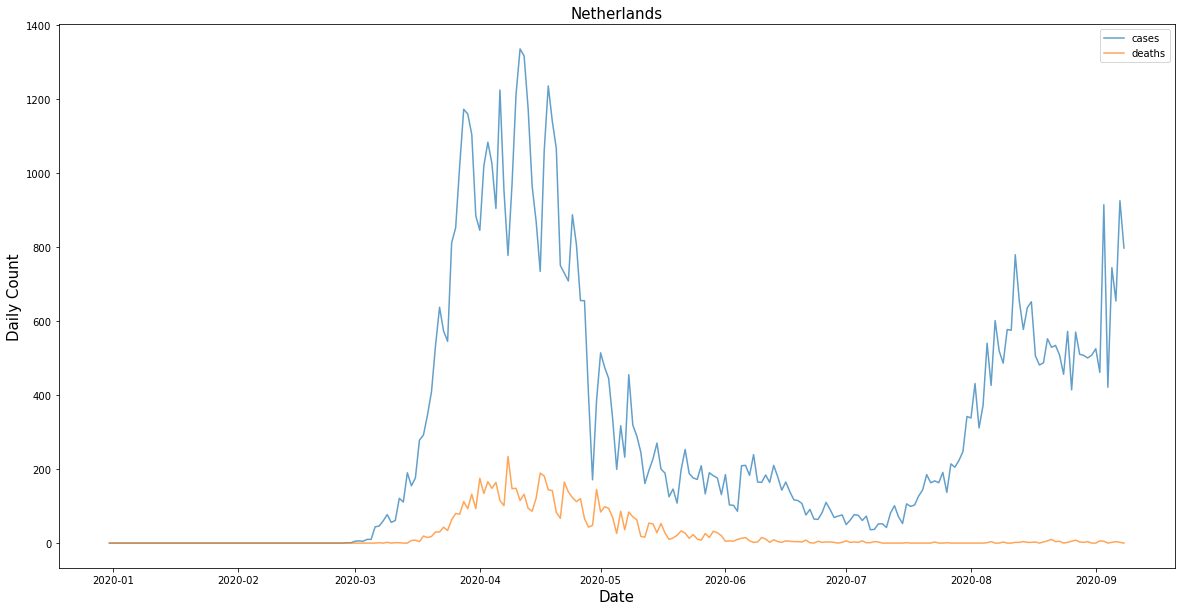

In [22]:
for i in ['cases', 'deaths']:
    plt.rcParams["figure.figsize"] = [20,10]
    plt.plot(covid_df_country['date'],covid_df_country[i], alpha=0.7, label=i)
    plt.legend(loc="upper right")
plt.title(country, fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Daily Count', fontsize=15)
